In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import csv
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
import numpy as np

def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]

def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot([[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda', index=0)

In [0]:
data_1 = sample_data_1()
data_2 = sample_data_2()
data_3, labels_3 = sample_data_3()

In [0]:
class VAEEncoder(nn.Module):
    def __init__(self, dim, lin_dim):
        super().__init__()
        self.dim = dim
        self.lin_dim=lin_dim
        self.linear = nn.Linear(dim, lin_dim)
        self.relu = nn.ReLU()
        
    def encode(self, x, muf, sigmaf):
        z = self.forward(x)
        mu = muf(z)
        sigma = sigmaf(z)
        return mu, torch.exp(sigma)
        
    def forward(self, x):
        z = self.linear(x)
        z = self.relu(z)
        return z

class VAEDecoder(nn.Module):
    def __init__(self, dim, lin_dim):
        super().__init__()
        self.dim = dim
        self.lin_dim=lin_dim
        self.linear = nn.Linear(dim, lin_dim)
        self.relu = nn.ReLU()
        
    def decode(self, x, muf, sigmaf):
        z = self.forward(x)
        mu = muf(z)
        sigma = sigmaf(z)
        return mu, torch.exp(sigma)        
        
    def forward(self, x):
        z = self.linear(x)
        z = self.relu(z)
        return z
        
class VAE(nn.Module):
    def __init__(self, latd=2, ind=2, lin_dim=64):
        super().__init__()
        self.latd = latd
        self.ind = ind
        self.encoder = VAEEncoder(ind, lin_dim)
        self.decoder = VAEDecoder(latd, lin_dim)
        self.mu_encode = nn.Linear(lin_dim, ind)
        self.mu_decode = nn.Linear(lin_dim, latd)
        self.sigma_encode = nn.Linear(lin_dim, ind)
        self.sigma_decode = nn.Linear(lin_dim, latd)
        self.normd = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        
    def sample(self, mu, sigma):
        if not self.training:
            return mu
        standard = self.normd.sample(mu.shape).to(device).view(mu.shape)
        return mu + standard * torch.sqrt(sigma)
    
    def forward(self, x):
        mu_z, sigma_z = self.encoder.encode(x, self.mu_encode, self.sigma_encode)
        z = self.sample(mu_z, sigma_z)
        mu_x, sigma_x = self.decoder.decode(z, self.mu_decode, self.sigma_decode)
        return mu_z, sigma_z, mu_x, sigma_x
        

In [0]:
  def print_losses(train_loss, test_loss):
    plt.plot(train_loss, 'g', label='Training loss')
    plt.plot(test_loss, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [0]:
class KLLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, mu, sigma):
        tr = sigma.sum(dim=-1)
        mu_sq = (mu ** 2).sum(dim=-1)
        det = sigma.prod(dim=-1)
        return torch.mean(tr + mu_sq - 2 - torch.log(det)) / 2
    
class VAECrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, mu, sigma):
        return torch.mean((torch.log(sigma * 2 * np.pi) + ((x - mu) ** 2 / sigma)).sum(dim=-1) / 2)


class VAELoss(nn.Module):
    def __init__(self, kl_loss, cross_entropy):
        super().__init__()
        self.kl_loss = kl_loss
        self.cross_entropy = cross_entropy
        
    def forward(self, x, mu_x, sigma_x, mu_z, sigma_z):
        self.kl_item = self.kl_loss(mu_z, sigma_z)
        self.cross_entropy_item = self.cross_entropy(x, mu_x, sigma_x)
        return self.kl_item + self.cross_entropy_item

In [184]:
VAE().to(device)(torch.FloatTensor(np.array([[1.0, 1.0]])).to(device))

(tensor([[-0.3202, -0.2748]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[2.3496, 0.8083]], device='cuda:0', grad_fn=<ExpBackward>),
 tensor([[ 0.0185, -0.1607]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[0.9495, 1.1902]], device='cuda:0', grad_fn=<ExpBackward>))

In [0]:
model = VAE().to(device)
opt = torch.optim.Adam(params=model.parameters())
loss = VAELoss(KLLoss(), VAECrossEntropyLoss())
loss = loss.to(device)

In [0]:
def train(model, opt, criterion, data, n_epoch, batch_size):
    data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False)
    
    train_loss_ce = []
    test_loss_ce = []
    train_loss_kl = []
    test_loss_kl = []
    for epoch in tqdm(range(n_epoch)):
      model.train()
      train_loss_ce_epoch = []
      test_loss_ce_epoch = []
      train_loss_kl_epoch = []
      test_loss_kl_epoch = []
      for batch in train_loader:
        opt.zero_grad()
        batch = batch.float()
        batch = batch.to(device)
        mu_z, sigma_z, mu_x, sigma_x = model(batch)
        loss = criterion(batch, mu_x, sigma_x, mu_z, sigma_z)
        train_loss_ce_epoch.append(criterion.cross_entropy_item.item())
        train_loss_kl_epoch.append(criterion.kl_item.item())
        loss.backward()
        opt.step()
      train_loss_ce.append(np.mean(train_loss_ce_epoch))
      train_loss_kl.append(np.mean(train_loss_kl_epoch))

      with torch.no_grad():
        model.eval()
        for batch in test_loader:
          batch = batch.float()
          batch = batch.to(device)
          mu_z, sigma_z, mu_x, sigma_x = model(batch)
          loss = criterion(batch, mu_x, sigma_x, mu_z, sigma_z)
          test_loss_ce_epoch.append(criterion.cross_entropy_item.item())
          test_loss_kl_epoch.append(criterion.kl_item.item())
        test_loss_ce.append(np.mean(test_loss_ce_epoch))
        test_loss_kl.append(np.mean(test_loss_kl_epoch))
    
    return train_loss_ce, train_loss_kl, test_loss_ce, test_loss_kl

In [187]:
train_loss_ce, train_loss_kl, test_loss_ce, test_loss_kl = train(model, opt, loss, data_1, 1000, 10000)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<08:51,  1.88it/s]

  0%|          | 2/1000 [00:01<08:59,  1.85it/s]

  0%|          | 3/1000 [00:01<08:54,  1.87it/s]

  0%|          | 4/1000 [00:02<08:45,  1.90it/s]

  0%|          | 5/1000 [00:02<08:41,  1.91it/s]

  1%|          | 6/1000 [00:03<08:39,  1.91it/s]

  1%|          | 7/1000 [00:03<08:42,  1.90it/s]

  1%|          | 8/1000 [00:04<08:37,  1.92it/s]

  1%|          | 9/1000 [00:04<08:35,  1.92it/s]

  1%|          | 10/1000 [00:05<08:35,  1.92it/s]

  1%|          | 11/1000 [00:05<08:34,  1.92it/s]

  1%|          | 12/1000 [00:06<08:37,  1.91it/s]

  1%|▏         | 13/1000 [00:06<08:34,  1.92it/s]

  1%|▏         | 14/1000 [00:07<08:38,  1.90it/s]

  2%|▏         | 15/1000 [00:07<08:40,  1.89it/s]

  2%|▏         | 16/1000 [00:08<08:50,  1.86it/s]

  2%|▏         | 17/1000 [00:08<08:45,  1.87it/s]

  2%|▏         | 18/1000 [00:09<08:45,  1.87it/s]

  2%|▏         | 19/1000 [00:10<09:00,  1.81it/

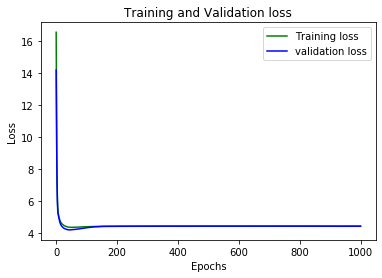

In [188]:
print_losses(train_loss_ce, test_loss_ce)

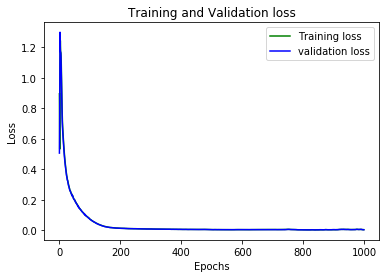

In [189]:
print_losses(train_loss_kl, test_loss_kl)

In [190]:
model.normd.sample([1,1]).to(device)

tensor([[[-0.0197]]], device='cuda:0')

In [0]:
def print_samples(model):
  n = 100000
  with torch.no_grad():
    model.eval()
    dots = model.normd.sample([n, 2]).to(device).view(-1,2)
    mu_x, sigma_x = model.decoder.decode(dots, model.mu_decode, model.sigma_decode)
    result_without_noize = model.sample(mu_x, sigma_x).cpu()
    model.train()
    result_with_noize = model.sample(mu_x, sigma_x).cpu()
    plt.plot(result_with_noize[:,0], result_with_noize[:,1], 'o', label='With noize')
    plt.plot(result_without_noize[:,0], result_without_noize[:,1], 'o', label='Without noize')
    plt.legend()
    plt.show()

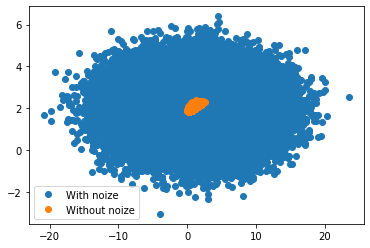

In [192]:
print_samples(model)

In [0]:
model = VAE().to(device)
opt = torch.optim.Adam(params=model.parameters())
loss = VAELoss(KLLoss(), VAECrossEntropyLoss())
loss = loss.to(device)

In [194]:
train_loss_ce, train_loss_kl, test_loss_ce, test_loss_kl = train(model, opt, loss, data_2, 100, 10000)



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:56,  1.76it/s]

  2%|▏         | 2/100 [00:01<00:53,  1.82it/s]

  3%|▎         | 3/100 [00:01<00:52,  1.84it/s]

  4%|▍         | 4/100 [00:02<00:52,  1.83it/s]

  5%|▌         | 5/100 [00:02<00:52,  1.82it/s]

  6%|▌         | 6/100 [00:03<00:51,  1.83it/s]

  7%|▋         | 7/100 [00:03<00:49,  1.87it/s]

  8%|▊         | 8/100 [00:04<00:49,  1.86it/s]

  9%|▉         | 9/100 [00:04<00:50,  1.79it/s]

 10%|█         | 10/100 [00:05<00:50,  1.78it/s]

 11%|█         | 11/100 [00:05<00:48,  1.84it/s]

 12%|█▏        | 12/100 [00:06<00:47,  1.87it/s]

 13%|█▎        | 13/100 [00:07<00:45,  1.89it/s]

 14%|█▍        | 14/100 [00:07<00:45,  1.88it/s]

 15%|█▌        | 15/100 [00:08<00:44,  1.90it/s]

 16%|█▌        | 16/100 [00:08<00:45,  1.85it/s]

 17%|█▋        | 17/100 [00:09<00:44,  1.87it/s]

 18%|█▊        | 18/100 [00:09<00:43,  1.87it/s]

 19%|█▉        | 19/100 [00:10<00:43,  1.87it/s]

 20%|██        |

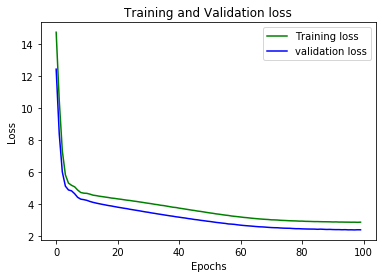

In [195]:
print_losses(train_loss_ce, test_loss_ce)

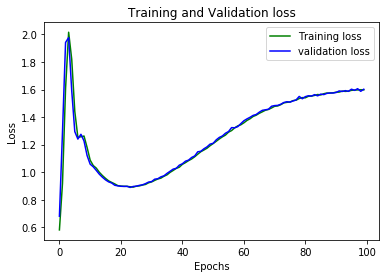

In [196]:
print_losses(train_loss_kl, test_loss_kl)

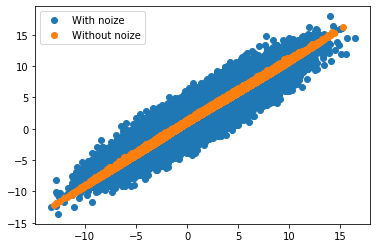

In [197]:
print_samples(model)

In [0]:
class VAE2(nn.Module):
    def __init__(self, latd=2, ind=2, lin_dim=64):
        super().__init__()
        self.latd = latd
        self.ind = ind
        self.encoder = VAEEncoder(ind, lin_dim)
        self.decoder = VAEDecoder(latd, lin_dim)
        self.mu_encode = nn.Linear(lin_dim, ind)
        self.mu_decode = nn.Linear(lin_dim, latd)
        self.sigma_encode = nn.Linear(lin_dim, ind // 2)
        self.sigma_decode = nn.Linear(lin_dim, latd // 2)
        self.normd = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        
    def sample(self, mu, sigma):
        if not self.training:
            return mu
        standard = self.normd.sample(mu.shape).to(device).view(mu.shape)
        return mu + standard * torch.sqrt(sigma)
    
    def forward(self, x):
        mu_z, sigma_z = self.encoder.encode(x, self.mu_encode, self.sigma_encode)
        sigma_z = torch.cat((sigma_z, sigma_z), axis=-1)
        z = self.sample(mu_z, sigma_z)
        mu_x, sigma_x = self.decoder.decode(z, self.mu_decode, self.sigma_decode)
        sigma_x = torch.cat((sigma_x, sigma_x), axis=-1)
        return mu_z, sigma_z, mu_x, sigma_x

In [0]:
model = VAE2().to(device)
opt = torch.optim.Adam(params=model.parameters())
loss = VAELoss(KLLoss(), VAECrossEntropyLoss())
loss = loss.to(device)

In [200]:
train_loss_ce, train_loss_kl, test_loss_ce, test_loss_kl = train(model, opt, loss, data_1, 100, 10000)



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:51,  1.94it/s]

  2%|▏         | 2/100 [00:01<00:52,  1.88it/s]

  3%|▎         | 3/100 [00:01<00:50,  1.91it/s]

  4%|▍         | 4/100 [00:02<00:49,  1.93it/s]

  5%|▌         | 5/100 [00:02<00:49,  1.92it/s]

  6%|▌         | 6/100 [00:03<00:48,  1.94it/s]

  7%|▋         | 7/100 [00:03<00:47,  1.95it/s]

  8%|▊         | 8/100 [00:04<00:47,  1.95it/s]

  9%|▉         | 9/100 [00:04<00:46,  1.94it/s]

 10%|█         | 10/100 [00:05<00:45,  1.96it/s]

 11%|█         | 11/100 [00:05<00:45,  1.98it/s]

 12%|█▏        | 12/100 [00:06<00:44,  1.99it/s]

 13%|█▎        | 13/100 [00:06<00:45,  1.90it/s]

 14%|█▍        | 14/100 [00:07<00:44,  1.94it/s]

 15%|█▌        | 15/100 [00:07<00:43,  1.94it/s]

 16%|█▌        | 16/100 [00:08<00:43,  1.93it/s]

 17%|█▋        | 17/100 [00:08<00:44,  1.88it/s]

 18%|█▊        | 18/100 [00:09<00:44,  1.84it/s]

 19%|█▉        | 19/100 [00:09<00:43,  1.86it/s]

 20%|██        |

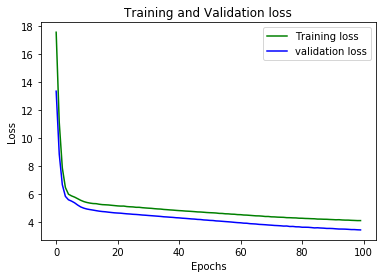

In [201]:
print_losses(train_loss_ce, test_loss_ce)

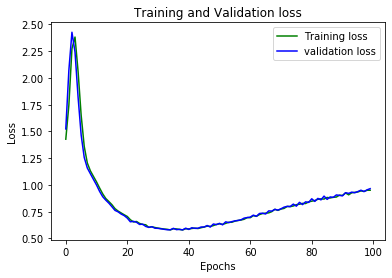

In [202]:
print_losses(train_loss_kl, test_loss_kl)

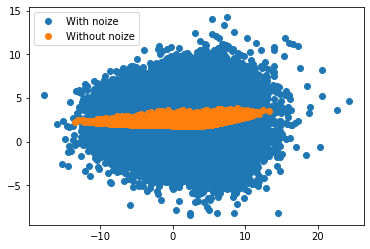

In [203]:
print_samples(model)

In [204]:
model = VAE2().to(device)
opt = torch.optim.Adam(params=model.parameters())
loss = VAELoss(KLLoss(), VAECrossEntropyLoss())
loss = loss.to(device)
train_loss_ce, train_loss_kl, test_loss_ce, test_loss_kl = train(model, opt, loss, data_2, 100, 10000)



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:55,  1.78it/s]

  2%|▏         | 2/100 [00:01<00:53,  1.82it/s]

  3%|▎         | 3/100 [00:01<00:51,  1.87it/s]

  4%|▍         | 4/100 [00:02<00:51,  1.85it/s]

  5%|▌         | 5/100 [00:02<00:50,  1.88it/s]

  6%|▌         | 6/100 [00:03<00:48,  1.92it/s]

  7%|▋         | 7/100 [00:03<00:48,  1.92it/s]

  8%|▊         | 8/100 [00:04<00:47,  1.93it/s]

  9%|▉         | 9/100 [00:04<00:47,  1.92it/s]

 10%|█         | 10/100 [00:05<00:46,  1.92it/s]

 11%|█         | 11/100 [00:05<00:46,  1.93it/s]

 12%|█▏        | 12/100 [00:06<00:45,  1.92it/s]

 13%|█▎        | 13/100 [00:06<00:44,  1.94it/s]

 14%|█▍        | 14/100 [00:07<00:45,  1.87it/s]

 15%|█▌        | 15/100 [00:07<00:45,  1.88it/s]

 16%|█▌        | 16/100 [00:08<00:44,  1.87it/s]

 17%|█▋        | 17/100 [00:08<00:43,  1.89it/s]

 18%|█▊        | 18/100 [00:09<00:43,  1.90it/s]

 19%|█▉        | 19/100 [00:09<00:42,  1.91it/s]

 20%|██        |

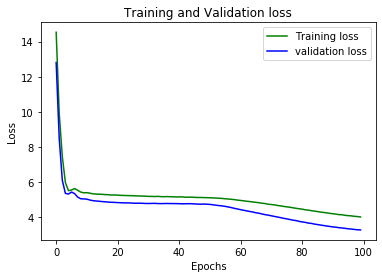

In [205]:
print_losses(train_loss_ce, test_loss_ce)

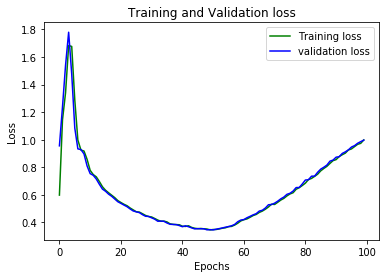

In [206]:
print_losses(train_loss_kl, test_loss_kl)

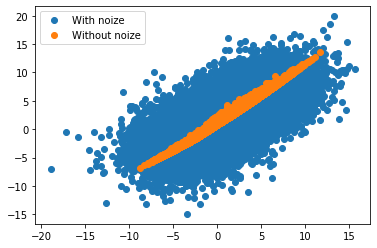

In [207]:
print_samples(model)

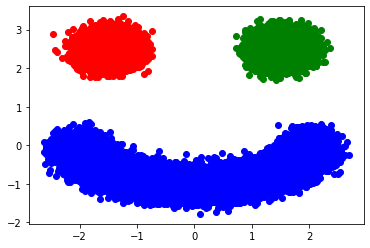

In [208]:
plt.plot(data_3[labels_3 == 0][:,0], data_3[labels_3 == 0][:,1], 'ro')
plt.plot(data_3[labels_3 == 1][:,0], data_3[labels_3 == 1][:,1], 'go')
plt.plot(data_3[labels_3 == 2][:,0], data_3[labels_3 == 2][:,1], 'bo')

In [209]:
model = VAE().to(device)
opt = torch.optim.Adam(params=model.parameters())
loss = VAELoss(KLLoss(), VAECrossEntropyLoss())
loss = loss.to(device)
train_loss_ce, train_loss_kl, test_loss_ce, test_loss_kl = train(model, opt, loss, data_3, 100, 10000)



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:55,  1.78it/s]

  2%|▏         | 2/100 [00:01<00:53,  1.82it/s]

  3%|▎         | 3/100 [00:01<00:51,  1.87it/s]

  4%|▍         | 4/100 [00:02<00:51,  1.87it/s]

  5%|▌         | 5/100 [00:02<00:49,  1.90it/s]

  6%|▌         | 6/100 [00:03<00:50,  1.87it/s]

  7%|▋         | 7/100 [00:03<00:49,  1.89it/s]

  8%|▊         | 8/100 [00:04<00:49,  1.86it/s]

  9%|▉         | 9/100 [00:04<00:49,  1.84it/s]

 10%|█         | 10/100 [00:05<00:49,  1.81it/s]

 11%|█         | 11/100 [00:05<00:48,  1.85it/s]

 12%|█▏        | 12/100 [00:06<00:47,  1.86it/s]

 13%|█▎        | 13/100 [00:06<00:45,  1.90it/s]

 14%|█▍        | 14/100 [00:07<00:45,  1.89it/s]

 15%|█▌        | 15/100 [00:07<00:44,  1.92it/s]

 16%|█▌        | 16/100 [00:08<00:44,  1.90it/s]

 17%|█▋        | 17/100 [00:09<00:43,  1.91it/s]

 18%|█▊        | 18/100 [00:09<00:43,  1.89it/s]

 19%|█▉        | 19/100 [00:10<00:43,  1.87it/s]

 20%|██        |

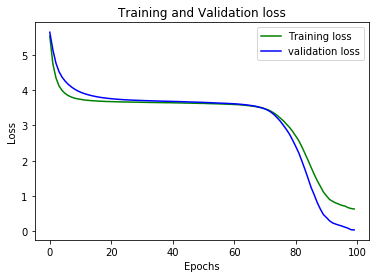

In [210]:
print_losses(train_loss_ce, test_loss_ce)

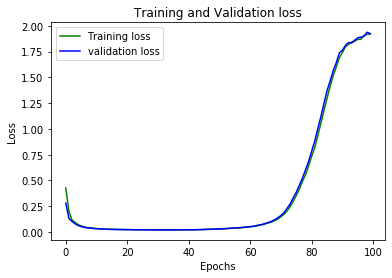

In [211]:
print_losses(train_loss_kl, test_loss_kl)

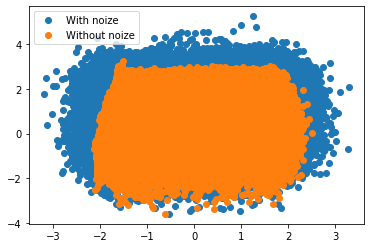

In [212]:
print_samples(model)

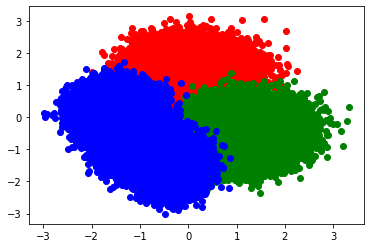

In [213]:
with torch.no_grad():
  mu_z, sigma_z = model.encoder.encode(torch.tensor(data_3).to(device).float(), model.mu_encode, model.sigma_encode)
  res = model.sample(mu_z, sigma_z)
  res = res.cpu()
  plt.plot(res[labels_3 == 0][:,0], res[labels_3 == 0][:,1], 'ro')
  plt.plot(res[labels_3 == 1][:,0], res[labels_3 == 1][:,1], 'go')
  plt.plot(res[labels_3 == 2][:,0], res[labels_3 == 2][:,1], 'bo')